In [1]:
import numpy as np
import math 
import networkx as nx
import itertools
import time
from sage.all import *
import h5py
from matplotlib import pyplot as plt
from pathlib import Path
import os

In [7]:
def find_graphs(n):
    Graphs = []
    Comps = []
    for G in graphs(n):
        if G.diameter()==3:
            H=G.complement()
            if H.diameter()==3:
                Graphs.append(G)
                Comps.append(H)
    return Graphs, Comps

In [11]:
class GraphObserver:

    def __init__(self, G):
        self.G = G.copy()
        self.fiedler_vec = sorted(self.G.kirchhoff_matrix().eigenvectors_right(),reverse=True)[-2][1][0]

    def show_graph(self):
        labels = []
        for i, label in enumerate(self.G.vertices()):
            labels.append(str(label) + ': ' + '{0:.2f}'.format(float(self.fiedler_vec[i])))
        self.G.plot(figsize=7, vertex_size=1800.0, vertex_labels=dict(zip(self.G, labels))).save('dominating_edge_characteristic_results/G_plot.png')

    def dom_edges(self):
        return [i for i in self.G.dominating_sets() if self.G.has_edge(i)]
    
    def comp_dom_edges(self):
        # Check to see if each pair has different sign
        pairs = self.dom_edges()
        found_counterexample = False
        for pair in pairs:
            a = pair[0]
            b = pair[1]
            vec_a = self.fiedler_vec[a]
            vec_b = self.fiedler_vec[b]
            if (vec_a > 0 and vec_b > 0) or (vec_a < 0 and vec_b < 0):
                print(pair)
                found_counterexample = True
                break
        return found_counterexample

In [10]:
Graphs = find_graphs(6)[0]

In [13]:
observer = GraphObserver(Graphs[0])
found_counterexample = observer.comp_dom_edges()
if found_counterexample:
    observer.show_graph()
print(found_counterexample)

False


In [2]:
L = np.array([
    [2,-1,-1,0,0,0],
    [-1,3,-1,-1,0,0],
    [-1,-1,3,0,-1,0],
    [0,-1,0,3,-1,-1],
    [0,0,-1,-1,3,-1],
    [0,0,0,-1,-1,2],
])

In [3]:
def get_submatrix(L, vertices_to_remove):
    rows = L[vertices_to_remove,:]
    cols = L[:,vertices_to_remove]
    submatrix_rows_parsed = np.delete(L, vertices_to_remove, axis=0)
    submatrix = np.delete(submatrix_rows_parsed, vertices_to_remove, axis=1)
    return submatrix, rows, cols

In [4]:
submatrix, rows, cols = get_submatrix(L, [1,2])
submatrix, rows, cols

(array([[ 2,  0,  0,  0],
        [ 0,  3, -1, -1],
        [ 0, -1,  3, -1],
        [ 0, -1, -1,  2]]),
 array([[-1,  3, -1, -1,  0,  0],
        [-1, -1,  3,  0, -1,  0]]),
 array([[-1, -1],
        [ 3, -1],
        [-1,  3],
        [-1,  0],
        [ 0, -1],
        [ 0,  0]]))

In [ ]:
bottleneck = np.linalg.inv(submatrix)
bottleneck

array([[0.5  , 0.   , 0.   , 0.   ],
       [0.   , 0.625, 0.375, 0.5  ],
       [0.   , 0.375, 0.625, 0.5  ],
       [0.   , 0.5  , 0.5  , 1.   ]])

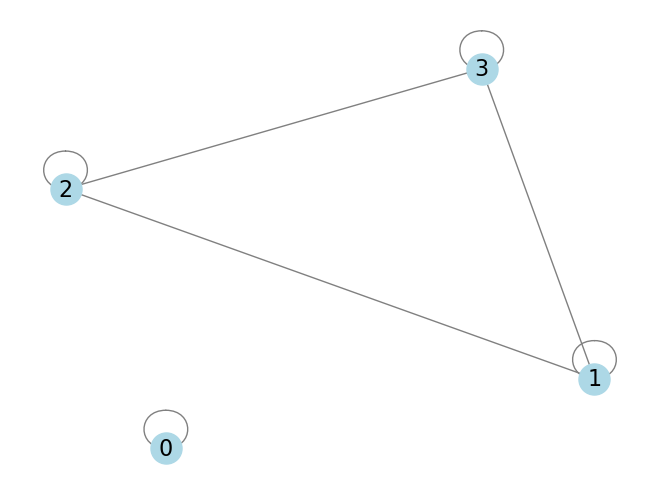

In [6]:
G = nx.from_numpy_array(submatrix)
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, font_size=16)
plt.show()

### Testing Lemma 2.4 from The Algebraic Connectivity of Graphs under Perturbation

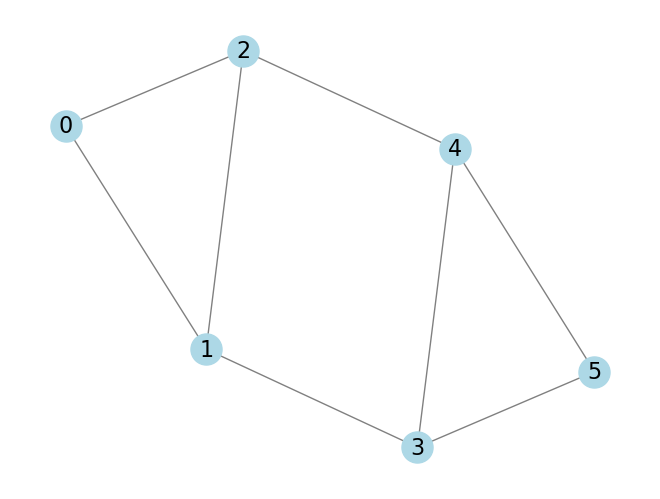

[2.73205081e+00 1.41421356e+00 1.41421356e+00 7.32050808e-01
 6.83580866e-17 2.00000000e+00]
0.0
7.632783294297951e-17


In [7]:
# Example adjacency matrix
adj_matrix = np.array([
    [0, 1, 1, 0, 0, 0],
    [1, 0, 1, 1, 0, 0],
    [1, 1, 0, 0, 1, 0],
    [0, 1, 0, 0, 1, 1],
    [0, 0, 1, 1, 0, 1],
    [0, 0, 0, 1, 1, 0]
])

adj_matrix_sub1 = np.array([
    [0]
])

adj_matrix_sub2 = np.array([
    [0, 1, 1],
    [1, 0, 1],
    [0, 1, 1]
])
 
# Create a NetworkX graph from the adjacency matrix
G = nx.from_numpy_array(adj_matrix)

nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, font_size=16)
plt.show()

print(np.abs(np.linalg.eigvals(adj_matrix)))
print(np.min(np.abs(np.linalg.eigvals(adj_matrix_sub1))))
print(np.min(np.abs(np.linalg.eigvals(adj_matrix_sub2))))

### Checking cut vertex groups

In [8]:
# Example adjacency matrix
adj_matrix = np.array([
    [0, 1, 0, 0, 0],
    [1, 0, 1, 0, 0],
    [0, 1, 0, 0, 0],
    [0, 0, 0, 0, 1],
    [0, 0, 0, 1, 0]
])

# Create a NetworkX graph from the adjacency matrix
G = nx.from_numpy_array(adj_matrix)

# Find the connected components
connected_components = list(nx.connected_components(G))

# Function to get the adjacency matrix of a component
def get_adj_matrix(component, graph):
    subgraph = graph.subgraph(component)
    adj_matrix = nx.adjacency_matrix(subgraph).todense()
    return adj_matrix

# Output the connected components and their adjacency matrices
# Find the one with the largest spectral radius
max_perron_val, perron_component = 0, 0
for i, component in enumerate(connected_components):
    adj_matrix = get_adj_matrix(component, G)
    spec_rad = np.max(np.abs(np.linalg.eigvals(adj_matrix)))
    if spec_rad > max_perron_val:
        max_perron_val = spec_rad
        perron_component = i
    print(f"Component: {component}")
    print("Adjacency matrix:")
    print(adj_matrix)

print(max_perron_val, perron_component)

Component: {0, 1, 2}
Adjacency matrix:
[[0 1 0]
 [1 0 1]
 [0 1 0]]
Component: {3, 4}
Adjacency matrix:
[[0 1]
 [1 0]]
1.4142135623730951 0


### Empirical Testing of Characteristic Dominating Edges

Unbalanced Dandelion Graph

In [9]:
n = 2000
A = np.diag(np.ones(n))
A[0,0] = 1
A[1,0], A[0,1], A[2,1], A[1,2] = -1, -1, -1, -1
A[1,1] = 2
A[2,2] = n-2
A[3:,2] = -1
A[2,3:] = -1
eig_vals, eig_vecs = np.linalg.eig(A)

fiedler_index = np.argsort(eig_vals)[1]
fiedler_value = eig_vals[fiedler_index]
fiedler_vector = eig_vecs[:,fiedler_index]

print(fiedler_value, '\n\n', fiedler_vector)
print(f"\n{A}\n")
print(np.sign(fiedler_vector[1]), np.sign(fiedler_vector[2]))

(0.3821897950843174+0j) 

 [-8.50332908e-01+0.j -5.25344348e-01+0.j  4.25460488e-04+0.j ...
  6.88658887e-04+0.j  6.88658887e-04+0.j  6.88658887e-04+0.j]

[[ 1.000e+00 -1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00  0.000e+00]
 [-1.000e+00  2.000e+00 -1.000e+00 ...  0.000e+00  0.000e+00  0.000e+00]
 [ 0.000e+00 -1.000e+00  1.998e+03 ... -1.000e+00 -1.000e+00 -1.000e+00]
 ...
 [ 0.000e+00  0.000e+00 -1.000e+00 ...  1.000e+00  0.000e+00  0.000e+00]
 [ 0.000e+00  0.000e+00 -1.000e+00 ...  0.000e+00  1.000e+00  0.000e+00]
 [ 0.000e+00  0.000e+00 -1.000e+00 ...  0.000e+00  0.000e+00  1.000e+00]]

(-1+0j) (1+0j)


Unbalanced Complement Dandelion Graph

In [10]:
n = 2000
A = -np.ones((n,n))
A = A + np.eye(n)*(n-1)
A[0,0], A[n-1, n-1] = 1, n-3
A[0,2:] = 0
A[2:,0] = 0
A[1,-1] = 0
A[-1,1] = 0

eig_vals, eig_vecs = np.linalg.eig(A)

fiedler_index = np.argsort(eig_vals)[1]
fiedler_value = eig_vals[fiedler_index]
fiedler_vector = eig_vecs[:,fiedler_index]

print(fiedler_value, '\n')
print(fiedler_vector)
print(f"\n{A}\n")
print(np.sign(fiedler_vector[1]), np.sign(fiedler_vector[2]))

(0.9999997493737502+0j) 

[ 9.99749844e-01+0.j  2.50563554e-07+0.j -5.00375297e-04+0.j ...
 -5.00375297e-04+0.j -5.00375297e-04+0.j -5.00625986e-04+0.j]

[[ 1.000e+00 -1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00  0.000e+00]
 [-1.000e+00  1.998e+03 -1.000e+00 ... -1.000e+00 -1.000e+00  0.000e+00]
 [ 0.000e+00 -1.000e+00  1.998e+03 ... -1.000e+00 -1.000e+00 -1.000e+00]
 ...
 [ 0.000e+00 -1.000e+00 -1.000e+00 ...  1.998e+03 -1.000e+00 -1.000e+00]
 [ 0.000e+00 -1.000e+00 -1.000e+00 ... -1.000e+00  1.998e+03 -1.000e+00]
 [ 0.000e+00  0.000e+00 -1.000e+00 ... -1.000e+00 -1.000e+00  1.997e+03]]

(1+0j) (-1+0j)


Unbalanced Dandelion Web Graph

In [27]:
n = 10000
A = np.diag(np.ones(n))
A[0,0] = 1
A[1,0], A[0,1], A[2,1], A[1,2] = -1, -1, -1, -1
A[1,1] = 2
A[2:,2:] = -1
A[2,2] = n-2
indices = np.arange(A.shape[0])
A[indices[3:], indices[3:]] = n-3

eig_vals, eig_vecs = np.linalg.eig(A)

fiedler_index = np.argsort(eig_vals)[1]
fiedler_value = eig_vals[fiedler_index]
fiedler_vector = eig_vecs[:,fiedler_index]

print(fiedler_value, '\n\n', fiedler_vector[:4])
# print(f"\n{A}\n")
print('\n')
print(fiedler_vector[1], fiedler_vector[2])
print(np.sign(fiedler_vector[1]), np.sign(fiedler_vector[2]))

(0.38201073968579274+0j) 

 [ 8.50587243e-01+0.j  5.25653781e-01+0.j -8.50704812e-05+0.j
 -1.37656892e-04+0.j]


(0.5256537810910769+0j) (-8.50704811881969e-05+0j)
(1+0j) (-1+0j)
